In [4]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

In [5]:
path = "./data"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
                             # transforms.Lambda(shear),
                             transforms.RandomSizedCrop(224),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             normalize,
                                 ])

data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                num_workers=4,
                                                batch_size=8,
                                                pin_memory=True,
                                                shuffle = True)
                     for x in ["train", "val"]}

/usr/local/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.


In [6]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [7]:
classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)

['cat', 'dog']
{'cat': 0, 'dog': 1}


In [8]:
print(u"训练集个数:", len(data_image["train"]))
print(u"验证集个数:", len(data_image["val"]))

训练集个数: 22500
验证集个数: 2500


['dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat']


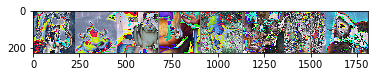

In [9]:
X_train, y_train = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [10]:
import torchvision.models as models
model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__"))
model_names

['alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [11]:
arch = 'vgg16_bn'
# vgg16 epoch=10  , score = 0.11116
# vgg16_bn epoch=5 , score = 0.52771

In [12]:
model = models.__dict__[arch](pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/user_00/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [02:15<00:00, 4090222.26it/s] 


In [13]:
# model = models.vgg16(pretrained=True)

In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [15]:
lr = 1e-2
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))


    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.classifier.parameters(),lr, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

In [16]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [17]:
n_epochs = 5
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch {}/{} ".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "val"]:
        if param == "train":
            model.train = True
#             model = torch.nn.DataParallel(model)
        else:
            model.train = False

        running_loss = 0.0
        running_correct = 0 
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X, y = data
            if use_gpu:
                X, y  = Variable(X.cuda()), Variable(y.cuda())
            else:
                X, y = Variable(X), Variable(y)
        
            optimizer.zero_grad()
            y_pred = model(X)
            _, pred = torch.max(y_pred.data, 1)
        
            loss = cost(y_pred, y)
            if param =="train":
                loss.backward()
                optimizer.step()
            running_loss += loss.data[0]
            running_correct += torch.sum(pred == y.data)
            if batch%500 == 0 and param =="train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                      batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
            
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])

        print("{}  Loss: {:.4f},  Correct: {:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since   
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch 0/5 
----------
Batch 500, Train Loss:0.0784, Train ACC:171.9000
Batch 1000, Train Loss:0.0641, Train ACC:177.3750
Batch 1500, Train Loss:0.0585, Train ACC:179.4500
Batch 2000, Train Loss:0.0557, Train ACC:180.0875
Batch 2500, Train Loss:0.0535, Train ACC:180.8200
train  Loss: 0.0263,  Correct: 90.5600
val  Loss: 0.0199,  Correct: 92.7600
Training time is:1m 59s
Epoch 1/5 
----------
Batch 500, Train Loss:0.0414, Train ACC:185.0500
Batch 1000, Train Loss:0.0424, Train ACC:184.9250
Batch 1500, Train Loss:0.0426, Train ACC:184.8333
Batch 2000, Train Loss:0.0416, Train ACC:185.3500
Batch 2500, Train Loss:0.0419, Train ACC:185.2000
train  Loss: 0.0207,  Correct: 92.7200
val  Loss: 0.0189,  Correct: 93.0800
Training time is:1m 59s
Epoch 2/5 
----------
Batch 500, Train Loss:0.0381, Train ACC:186.9500
Batch 1000, Train Loss:0.0390, Train ACC:186.5750
Batch 1500, Train Loss:0.0391, Train ACC:186.5833
Batch 2000, Train Loss:0.0390, Train ACC:186.7250
Batch 2500, Train Loss:0.0395, Train 

In [ ]:
torch.save(model.state_dict(), "model_%s_finetune.pkl" % arch)

In [ ]:
model.load_state_dict(torch.load('model_%s_finetune.pkl' % arch))

In [ ]:
dir(torch)

In [18]:
class ImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, path

In [19]:
data_test_img = ImageFolder(root="./test/",
                                     transform = transform)
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                   batch_size = 1)

In [ ]:
for a,b,c in data_loader_test_img:
    print(a)
    print(b)
    print(c)
    break

In [20]:
import collections
clip = 0.001
cnt = 1
csv_map = {}

for image, label, path in (data_loader_test_img):
    images = Variable(image.cuda())
    y_pred = model(images)
    smax = torch.nn.Softmax()
    smax_out = smax(y_pred)[0]
    cat_prob = smax_out.data[0]
    dog_prob = smax_out.data[1]
    prob = dog_prob

    if cat_prob > dog_prob:
        prob = 1 - cat_prob
    prob = np.around(prob, decimals=4)
    prob = np.clip(prob, clip, 1-clip)
    filepath = path[0].split('/')[-1].split('.')[-2]
    if filepath == '0':
        print(path)
        break
    csv_map[filepath] = prob
    


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [21]:
csv_list = []
for k,v in csv_map.items():
    csv_list.append((k,v))

In [22]:
len(csv_list)

12500

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame(csv_list)
df.columns = ['id','label']
df.id = df.id.astype(int)
df = df.sort_values('id')

In [25]:
df.to_csv('result_%s.csv' % arch,index=False)

In [ ]:
df.groupby('id').count()

In [ ]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = img*std+mean
print("Pred Label:",[classes[i] for i in pred])
plt.imshow(img)